In [261]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from matplotlib.pyplot import legend, title

sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [262]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
emeApi = lumapi.MODE()

Units

In [263]:
um = 1e-6
nm = 1e-9

Device parameters

In [278]:
#inverse tapers
taper_length      = 300*um
taper_larger_tip  = 0.55*um
taper_smaller_tip = 0.1*um
taper_tip_sweep = np.linspace(0.01*um, 0.55*um,25)

#wire waveguide
wg_length = 100*um
wg_width  = 0.55*um

#general
height = 0.34*um

Materials

In [265]:
materialClad = "SiO2 (Glass) - Palik"
materialSi = "Si (Silicon) - Palik"

In [266]:
emeApi.switchtolayout()
emeApi.deleteall()
emeApi.cleardcard

<bound method Lumerical.__init__.<locals>.<lambda>.<locals>.<lambda> of <lumapi.MODE object at 0x000001E059430260>>

Taper

In [267]:
emeApi.addobject('linear_taper')
emeApi.set('thickness', height)
emeApi.set('angle_side', 90)
emeApi.set('width_l', taper_smaller_tip)
emeApi.set('width_r', taper_larger_tip)
emeApi.set('len', taper_length)
emeApi.set('material', materialSi)
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('z', height/2)

Wire waveguide

In [268]:
emeApi.addrect()
emeApi.set('name', 'wire waveguide')
emeApi.set('x', (taper_length + wg_length)/2)
emeApi.set('x span', wg_length)
emeApi.set('y', 0)
emeApi.set('y span', wg_width)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

PECVD

In [269]:
'''emeApi.addrect()
emeApi.set('name', 'PECVD')
emeApi.set('x',0)
emeApi.set('x span', (wg_length + taper_length)*1.5)
emeApi.set('y', 0)
emeApi.set('y span', wg_width)
emeApi.set('z min', 0)
emeApi.set('z max', 0.5*um)
emeApi.set('material', materialClad)'''

"emeApi.addrect()\nemeApi.set('name', 'PECVD')\nemeApi.set('x',0)\nemeApi.set('x span', (wg_length + taper_length)*1.5)\nemeApi.set('y', 0)\nemeApi.set('y span', wg_width)\nemeApi.set('z min', 0)\nemeApi.set('z max', 0.5*um)\nemeApi.set('material', materialClad)"

Analysis    

In [270]:
emeApi.addfde()
emeApi.set('solver type', '2D X normal')
emeApi.set('x', -taper_length/2)
#emeApi.set('x span', wg_length+taper_length*1.5)
emeApi.set('y', 0)
emeApi.set('y span', wg_width*1.5)
emeApi.set('z', 0)
emeApi.set('background material', materialClad)

In [286]:
neff_TE_mode = []
neff_TM_mode = []
#TE
for i in range(len(taper_tip_sweep)):
    emeApi.switchtolayout()
    emeApi.setnamed('linear_taper','width_l', taper_tip_sweep[i])
    emeApi.run()
    emeApi.findmodes()
    neff_mode1 = emeApi.real(emeApi.getdata('mode1', 'TE polarization fraction'))
    neff_mode2 = emeApi.real(emeApi.getdata('mode2', 'TE polarization fraction'))
    if neff_mode1 > 0.5:
        neff_TE_mode.append(emeApi.real(emeApi.getdata('mode1', 'neff')))
    elif neff_mode1 < 0.5:
        neff_TM_mode.append(emeApi.real(emeApi.getdata('mode1', 'neff')))
    
    if neff_mode2 > 0.5:
        neff_TE_mode.append(emeApi.real(emeApi.getdata('mode2', 'neff')))
    elif neff_mode2 < 0.5:
        neff_TM_mode.append(emeApi.real(emeApi.getdata('mode2', 'neff')))
    
    

In [285]:
print(emeApi.real(emeApi.getdata('mode1', 'TE polarization fraction')))

0.993947596126489


In [1]:
plt.plot(taper_tip_sweep/um,neff_TE_mode, color='black', label='TE') 
plt.plot(taper_tip_sweep/um,neff_TM_mode, color='red', label='TM')
plt.xlabel('Taper tip width (\mu m)')
plt.ylabel('Effective index')
plt.grid()
plt.legend()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\luciv\AppData\Local\Temp\ipykernel_7116\1277004840.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Taper tip width (\mu m)')
C:\Users\luciv\AppData\Local\Temp\ipykernel_7116\1277004840.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Taper tip width (\mu m)')


NameError: name 'plt' is not defined

In [273]:
neff_interpol = interpolate.interp1d(taper_tip_sweep, neff_TE_mode)
neff_interpolSmooth = interpolate.UnivariateSpline(taper_tip_sweep, neff_TE_mode)
neff_interpolSmooth.set_smoothing_factor(500)

neff_interpol2 = interpolate.interp1d(taper_tip_sweep, neff_TM_mode)
neff_interpolSmooth = interpolate.UnivariateSpline(taper_tip_sweep, neff_TM_mode)
neff_interpolSmooth.set_smoothing_factor(500)

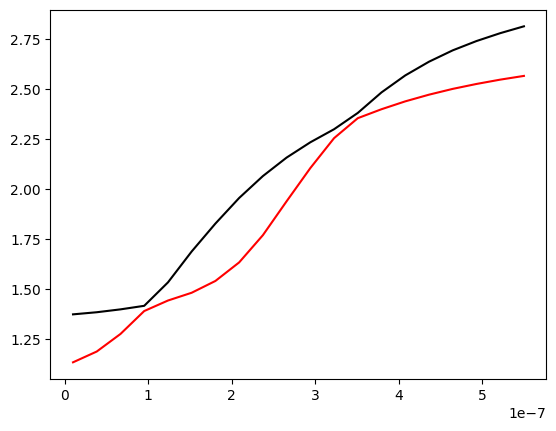

In [274]:
plt.plot(taper_tip_sweep, neff_interpol(taper_tip_sweep), color='black', label='TE')
plt.plot(taper_tip_sweep, neff_interpol2(taper_tip_sweep), color='red', label='TM')
plt.show()